In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

In [2]:
def preprocess(totalLabels,stats, centroids):
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

In [57]:
def preprocess_helper(df):
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    
    df = df[(df['area'] > 200) & (df['aspect_ratio'] > 1.9) & (df['area'] < 12000)]
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True)
    
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    thresh = 10

    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > thresh:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)

    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df

In [4]:
def plot_components(df,img,comps=[]):
    output = img.copy() 
    for comp in comps:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(output)

In [5]:
def plot_nn_patch(df,img,root_label, neighbor_labels):          
    output = img.copy()
    count = 0
    x,y,w,h = df[df['label_id'] == root_label][['left','top','width','height']].values[0]  
    print(df[df['label_id'] == root_label])
    cv2.rectangle(output, (x, y), (x + w, y + h),(255,0,0) , 2)
    for neighbor in neighbor_labels:
        count += 1
        x1,y1,w1,h1 = df[df['label_id'] == neighbor][['left','top','width','height']].values[0]
        cv2.rectangle(output, (x1, y1), (x1 + w1, y1 + h1),(0, 255,0) , 2)
        cv2.putText(output, str(count), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        #cv2.circle(output, (100, 100), 5, (255, 255, 255), -1)
    plt.imshow(output)

In [76]:
def build_single_lexicon(label_id, df, k=5):
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    x,y,w,h,r,c = df[df['label_id'] == label_id][['left','top','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #rotation-invariance
    
    #scale-invariance
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)/w
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])/h
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/h
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/h
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
     
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k]
    res_df = res_df.sort_values(by=['theta'])
    
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)           
    return res_df

In [77]:
def build_context_layout(img):
    bs = 5
    k = -0.2
    maxval = 255
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgThresh = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                               type=cv2.THRESH_BINARY,blockSize=bs,k=k)
    
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh,4,cv2.CV_32S)
    df = preprocess(totalLabels,stats, centroid)
    df = preprocess_helper(df)
    print("total no of words(>3 chars) identified:",df.shape[0])
    
    context_vectors = []
    k_neigh = 5
    for label in df.label_id.values:
        try:
            res = build_single_lexicon(label, df,k=k_neigh)
            if(res.shape[0] >= k_neigh):
                context_vectors.append(res[['tl_corner','br_corner']].values)
        except Exception as e:
            print()
            
    flattened_tuples = [np.array([item for sublist in t for item in sublist]) for t in context_vectors]
    array_of_tuples = np.array(flattened_tuples)
    context_vectors = array_of_tuples.reshape(len(context_vectors), k_neigh, 4)
    context_vectors = context_vectors.round(4)
    print("total no of contexts extracted:",context_vectors.shape[0])
    
    return context_vectors

In [78]:
def count_matches(query_vectors,doc_vectors):
    matches = np.all(query_vectors[:, np.newaxis] == doc_vectors, axis=(2, 3))
    num_matches = np.sum(matches, axis=1)
    num_matches = len(num_matches[num_matches == 1])
    return num_matches, 100*num_matches/len(query_vectors)

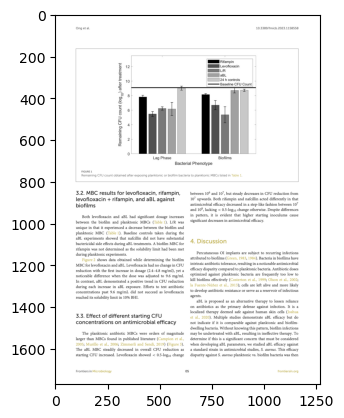

In [80]:
img_full = cv2.imread('./../../samples/imgPDF.png')
plt.imshow(img_full)

In [ ]:
img = img_full[930:1400, 20:630]
plt.imshow(img)

In [81]:
query_vectors = build_context_layout(img)
len(query_vectors)

total no of words(>3 chars) identified: 85
total no of contexts extracted: 85


85

In [83]:
doc_vectors = build_context_layout(img_full)
len(doc_vectors)

total no of words(>3 chars) identified: 291
total no of contexts extracted: 283


283

In [ ]:
count_matches(query_vectors,doc_vectors)

In [ ]:
count_matches(doc_vectors,query_vectors)

In [15]:
img.shape

(470, 610, 3)

In [16]:
asp_ratio = img.shape[1] / img.shape[0] 
asp_ratio

1.297872340425532

In [42]:
940 * asp_ratio

1220.0

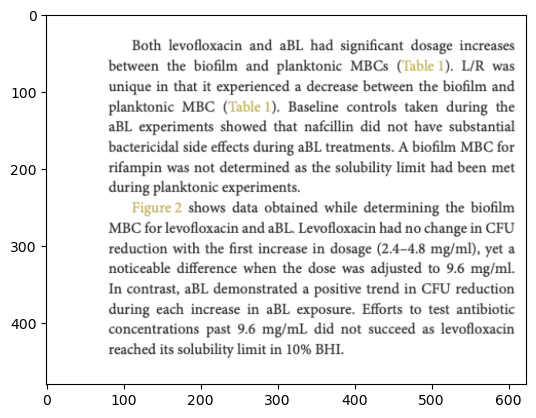

In [84]:
dimension = (623,480)
img2 = cv2.resize(img, dimension, interpolation=cv2.INTER_AREA)
plt.imshow(img2)

In [85]:
query2_vectors = build_context_layout(img2)
len(query2_vectors)

total no of words(>3 chars) identified: 75
total no of contexts extracted: 75


75

In [ ]:
count_matches(query2_vectors,doc_vectors)

In [61]:
query2_vectors.shape

(105, 5, 4)

In [62]:
count_matches(query2_vectors,query_vectors)

(0, 0.0)

In [63]:
query_vectors[0],query2_vectors[0]

(array([[ 1.119 ,  0.    ,  3.4524,  0.4524],
        [ 4.381 , -0.619 ,  6.4524, -0.0714],
        [ 6.5952, -0.6429,  7.8571, -0.2143],
        [-0.7143, -0.619 ,  0.9286, -0.1667],
        [ 1.881 , -0.619 ,  3.3095, -0.1667]]),
 array([[ 1.175,  0.   ,  3.575,  0.425],
        [ 4.7  , -0.025,  5.5  ,  0.375],
        [ 4.6  , -0.65 ,  6.725, -0.125],
        [-0.75 , -0.65 ,  0.925, -0.225],
        [ 1.975, -0.65 ,  3.425, -0.225]]))

In [49]:
query_vectors[1],query2_vectors[1]

(array([[ 2.3469, -0.2755,  2.8878, -0.0918],
        [-0.4796,  0.    , -0.051 ,  0.1939],
        [-0.7857, -0.2653, -0.0816, -0.0714],
        [ 0.3265, -0.2653,  0.9388, -0.0714],
        [ 1.398 , -0.2653,  2.2857, -0.0306]]),
 array([[ 1.0843,  0.    ,  1.747 ,  0.253 ],
        [-0.9277, -0.012 , -0.5422,  0.1807],
        [-0.9759, -0.3133,  0.0482, -0.0602],
        [ 0.1446, -0.3133,  0.759 , -0.1084],
        [ 0.8675, -0.3133,  1.4578, -0.0723]]))

In [50]:
np.subtract(query_vectors[1],query2_vectors[1])

array([[ 1.2626, -0.2755,  1.1408, -0.3448],
       [ 0.4481,  0.012 ,  0.4912,  0.0132],
       [ 0.1902,  0.048 , -0.1298, -0.0112],
       [ 0.1819,  0.048 ,  0.1798,  0.037 ],
       [ 0.5305,  0.048 ,  0.8279,  0.0417]])

In [51]:
np.abs(np.subtract(query_vectors[1],query2_vectors[1])).sum(axis=0)

array([2.6133, 0.4315, 2.7695, 0.4479])

In [27]:
np.subtract(query_vectors[0],query2_vectors[0])

array([[ 0.0281,  0.    ,  0.066 , -0.0021],
       [ 0.1083, -0.0054,  0.1569, -0.0032],
       [ 0.1634, -0.0065,  0.1753, -0.0098],
       [-0.0098, -0.0054,  0.0195, -0.0076],
       [ 0.0401, -0.0054,  0.0595, -0.0076]])

In [28]:
np.abs(np.subtract(query_vectors[0],query2_vectors[0])).sum(axis=0)

array([0.3497, 0.0227, 0.4772, 0.0303])

1. cosine
2. spacy similarity
3. hugging face similarity

In [29]:
query_vectors[0]/query2_vectors[0]

array([[1.02575855,        nan, 1.01948972, 0.99537954],
       [1.02534697, 1.00880052, 1.02492256, 1.04692082],
       [1.02540502, 1.0102137 , 1.02282017, 1.04792176],
       [1.01391057, 1.00880052, 1.02144979, 1.0477687 ],
       [1.02178282, 1.00880052, 1.01830769, 1.0477687 ]])

In [30]:
query_vectors[1]/query2_vectors[1]

array([[1.00868182, 0.99386724, 1.00574653, 1.03030303],
       [1.00925926,        nan, 1.28787879, 0.97929293],
       [1.00447456, 0.99251777, 1.03030303, 1.03030303],
       [0.99938782, 0.99251777, 0.99808633, 1.03030303],
       [1.00858524, 0.99251777, 1.00811538, 1.03030303]])

In [86]:
def verify_context_layout(img):
    _,imgThresh1 = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
    bs = 5
    k = -0.2
    maxval = 255
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgThresh2 = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                               type=cv2.THRESH_BINARY,blockSize=bs,k=k)
    
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh2,4,cv2.CV_32S)
    df = preprocess(totalLabels,stats, centroid)
    df = preprocess_helper(df)
    
    return df

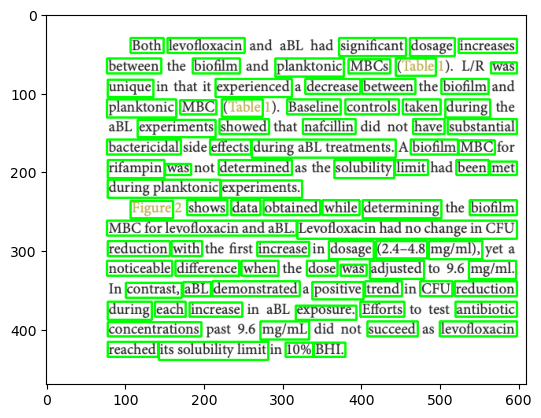

In [87]:
df = verify_context_layout(img)
plot_components(df,img,comps=df.label_id.unique())

In [ ]:
df2 = verify_context_layout(img2)
plot_components(df2,img2,comps=df2.label_id.unique())

In [88]:
df

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,columnID
0,2,107,30,42,19,388,128.515464,39.796392,2.21,1,1
1,3,154,30,98,19,937,201.500534,40.469584,5.16,1,2
2,7,372,30,85,23,892,413.839686,40.659193,3.70,1,3
3,8,462,30,57,23,538,490.334572,41.392193,2.48,1,4
4,9,524,31,74,18,712,559.702247,41.122191,4.11,1,5
...,...,...,...,...,...,...,...,...,...,...,...
80,335,78,391,119,18,1103,137.480508,401.002720,6.61,15,1
81,360,78,416,64,19,646,110.178019,426.411765,3.37,16,1
82,361,143,416,139,23,1527,212.889980,425.972495,6.04,16,2
83,363,304,417,35,18,377,320.816976,425.424403,1.94,16,3


In [89]:
df2

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,columnID
0,2,215,61,82,36,1310,257.903053,80.041221,2.28,1,1
1,3,309,61,194,36,3325,403.147068,81.348872,5.39,1,2
2,6,745,61,168,44,3197,827.762590,81.669690,3.82,1,4
3,7,925,61,112,44,1808,981.642146,83.227876,2.55,1,5
4,8,591,63,66,34,1090,623.190826,80.355046,1.94,1,3
...,...,...,...,...,...,...,...,...,...,...,...
91,410,157,833,126,36,2256,219.945035,853.549645,3.50,16,1
92,411,331,833,150,44,2993,409.975610,852.775810,3.41,16,2
93,412,483,833,80,36,1643,521.765064,851.582471,2.22,16,3
94,415,609,835,68,34,1244,641.965434,851.229904,2.00,16,4


In [90]:
n1 = build_single_lexicon(2, df, k=5)
np.round(n1[['tl_corner','br_corner']].T)

,2,5,6,7,1
tl_corner,"(6.309523809523809, 0.0)","(-0.7142857142857143, -1.368421052631579)","(1.880952380952381, -1.368421052631579)","(4.380952380952381, -1.368421052631579)","(1.119047619047619, 0.0)"
br_corner,"(8.333333333333332, 1.2105263157894737)","(0.9285714285714285, -0.368421052631579)","(3.3095238095238093, -0.368421052631579)","(6.4523809523809526, -0.1578947368421053)","(3.4523809523809526, 1.0)"


In [91]:
n2 = build_single_lexicon(2, df2, k=5)
n2[['tl_corner','br_corner']].T

,4,6,7,8,1
tl_corner,"(4.585365853658536, -0.05555555555555555)","(-0.7317073170731707, -1.4444444444444444)","(1.9268292682926829, -1.4444444444444444)","(4.487804878048781, -1.4444444444444444)","(1.146341463414634, 0.0)"
br_corner,"(5.390243902439024, 0.8888888888888888)","(0.9268292682926829, -0.4444444444444444)","(3.3658536585365852, -0.4444444444444444)","(6.585365853658537, -0.2222222222222221)","(3.512195121951219, 1.0)"


In [38]:
np.subtract(query_vectors[1],query2_vectors[1])

array([[ 0.0202,  0.0017,  0.0165, -0.0027],
       [-0.0044,  0.    , -0.0114, -0.0041],
       [-0.0035,  0.002 , -0.0024, -0.0021],
       [-0.0002,  0.002 , -0.0018, -0.0021],
       [ 0.0119,  0.002 ,  0.0184, -0.0009]])

In [39]:
np.sum(np.abs(query_vectors[1]-query2_vectors[1]))

0.11029999999999926

In [40]:
np.sum(np.abs(query_vectors[2]-query2_vectors[2]))

0.09459999999999989

In [41]:
np.sum(np.abs(query_vectors[0]-query2_vectors[0]))

0.8799000000000001

In [ ]:
def match_records(doc_vectors, query_vectors):
    match_count = 0
    for doc in doc_vectors:
        for query in query_vectors:
            sorted_doc_vectors = np.sort(doc, axis=(1))
            sorted_query_vectors = np.sort(query, axis=(1))
            if np.array_equal(sorted_doc_vectors, sorted_query_vectors):
                match_count += 1     
            else:
                print()
    return match_count

In [ ]:
count = 0
for q in doc_vectors:
    if q not in query_vectors:
        count += 1
count

In [ ]:
match_records(query_vectors, doc_vectors)

In [ ]:
match_records(query2_vectors, doc_vectors)

In [ ]:
def match_records(p, q):
    match_count = 0
    c = []
    for record_p in p:
        component_matches = 0
        m = 0
        for record_q in q:
            for i in range(5):
                component_p = record_p[i]  # Get the i-th component of record_p
                component_q = record_q[i]  # Get the i-th component of record_q

                # Check if the components match
                if np.array_equal(component_p, component_q):
                    component_matches += 1
            
            # If all 5 components match, increment the match_count
            if component_matches == 5:
                match_count += 1

    return match_count,c

In [ ]:
match_records(query_vectors, doc_vectors)

In [ ]:
def compute_distance_score(p, q):
    distance_scores = []

    for record_p in p:
        distances = [np.linalg.norm(record_p - record_q) for record_q in q]
        distance_scores.append(min(distances))  # Take the minimum distance for each record in p

    total_distance = sum(distance_scores)
    
    return total_distance

In [ ]:
compute_distance_score(query_vectors, query_vectors)

In [ ]:
compute_distance_score(query_vectors, doc_vectors)

In [ ]:
compute_distance_score(query_vectors, query2_vectors)

In [ ]:
compute_distance_score(query2_vectors,query_vectors)

In [ ]:
a = np.array([[1,1,2,3],[1,2,3]])
b = np.array([[1,1,2,3],[1,2,3]])

np.all(a == b)